# Decision Trees 

## Abstract
This notebook first trains different decision trees with different parameters and ensemble methods on a small data set. 
The following models were trained:
- Decision Tree
- Gradient Boosting Classifier
- Random Forest Trees
- AdaBoost

Finally, we trained three models on the complete dataset (still using train/test).
Following scores were archieved:

Ranking | Model | Score 
--- | --- | ---
1 | Random Forest Classifier with AdaBoost | 0.9998625929892037
2 | Random Forest Classifier | 0.9998540050510288
3 | Decision Tree Classifier with AdaBoost | 0.9998454171128541



## Import and Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from joblib import dump, load

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [1]:
import dask
import dask.dataframe as dd
import dask.array as da

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = dd.read_csv('datasets/prepared_ds.csv')

## Initialise Sample Dataframe

In [ ]:
df_fast = df.sample(frac=0.01, random_state = 1).compute()

## Train-Test-Split

In [37]:
train, test, train_lbl, test_lbl = train_test_split(df_fast.loc[:, ~df_fast.columns.isin(['Unnamed: 0', "Label"])], df_fast["Label"], test_size=0.2, random_state=1)
X = df_fast.loc[:, ~df_fast.columns.isin(['Unnamed: 0', "Label"])]
y = df_fast["Label"]

## Models

0.9964981830194912


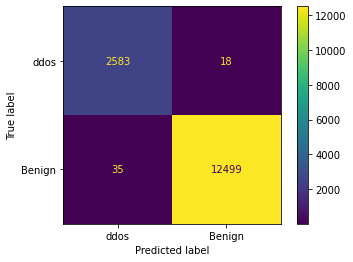

In [12]:
# Default Tree
clf = tree.DecisionTreeClassifier()
clf.fit(train, train_lbl)
score = clf.score(test, test_lbl)
print(score)
plot_confusion_matrix(clf, test, test_lbl, labels=['ddos', 'Benign']);

In [13]:
# Settings
criterion = ["gini", "entropy"]
splitter = ["best", "random"]

In [43]:
scores = []
found = False
best_clf = None
while not found:
    for c, s in list(itertools.product(criterion, splitter)):
        clf = tree.DecisionTreeClassifier()
        clf.fit(train, train_lbl)
        score = clf.score(test, test_lbl)
        string = f"criterion: {c}, splitter: {s}"
        scores.append([score, string])
        if score > 0.997:
            best_clf = clf
            found = True
            dump(clf, f"models/decision_tree_{score}.model")

In [29]:
scores.sort(reverse = True)
print(len(scores))
for score, string in scores[:10]:
    print(score, string)

8
0.9970267591674926 criterion: gini, splitter: random
0.9968946151304923 criterion: gini, splitter: random
0.9966963990749917 criterion: entropy, splitter: best
0.9965642550379914 criterion: gini, splitter: best
0.9965642550379914 criterion: entropy, splitter: random
0.9965642550379914 criterion: entropy, splitter: best
0.9964981830194912 criterion: gini, splitter: best
0.9964981830194912 criterion: entropy, splitter: random


0.9970267591674926


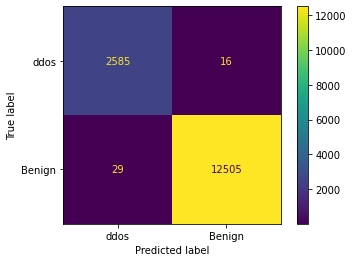

In [44]:
print(best_clf.score(test, test_lbl))
plot_confusion_matrix(best_clf, test, test_lbl, labels=['ddos', 'Benign']);

# Ensemble Methods

## GradientBoostingClassifier

In [14]:
loss = ["deviance", "exponential"]
learning_rate = [0.05, 0.1, 0.2, 1]
n_estimators = [90, 100, 130, 200]
criterion = ["friedman_mse", "mse", "mae"]

In [ ]:
scores_gdc = []
for l, lr, n, c in list(itertools.product(loss, learning_rate, n_estimators, criterion)):
    clf = GradientBoostingClassifier(loss = l, learning_rate = lr, n_estimators = n, criterion = c)
    clf.fit(train, train_lbl)
    score = clf.score(test, test_lbl)
    string = f"loss: {l}, learning_rate: {lr}, n_estimators: {n}, criterion: {c}"
    scores_gdc.append([score, string])
    print("-")

In [16]:
scores_gdc.sort(reverse = True)
print(len(scores_gdc))
for score, string in scores_gdc[:]:
    print(score, string)

2
0.9896927651139742 loss: deviance, learning_rate: 0.05, n_estimators: 90, criterion: mse
0.9896927651139742 loss: deviance, learning_rate: 0.05, n_estimators: 90, criterion: friedman_mse


0.9961678229269905


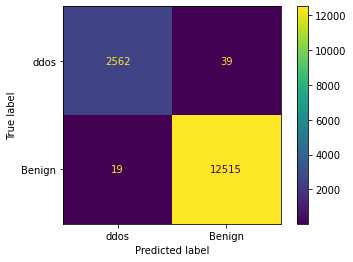

In [45]:
clf = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.08, n_estimators = 200, criterion = "mse")
clf.fit(train, train_lbl)
score = clf.score(test, test_lbl)
print(clf.score(test, test_lbl))
plot_confusion_matrix(clf, test, test_lbl, labels=['ddos', 'Benign']);

## Random Trees

In [32]:
n_estimators = np.linspace(10, 300, 20).astype(int)
bootstrap = [True, False] 
criterion = ["gini", "entropy"]

In [ ]:
scores_rt = []
for c, b, n in list(itertools.product(criterion, bootstrap, n_estimators)):
    clf = RandomForestClassifier(criterion = c, bootstrap = b, n_estimators = n)
    clf.fit(train2, train_lbl2)
    score = clf.score(test2, test_lbl2)
    string = f"criterion: {c}, bootstrap: {b}, n_estimators: {n}"
    scores_rt.append([score, string])

In [23]:
# df_fast 0.01
scores_rt.sort(reverse = True)
print(len(scores_rt))
for score, string in scores_rt[:10]:
    print(score, string)

80
0.9986785596299967 criterion: entropy, bootstrap: False, n_estimators: 40
0.9986124876114966 criterion: entropy, bootstrap: False, n_estimators: 25
0.9985464155929964 criterion: gini, bootstrap: False, n_estimators: 71
0.9985464155929964 criterion: gini, bootstrap: False, n_estimators: 300
0.9985464155929964 criterion: gini, bootstrap: False, n_estimators: 254
0.9985464155929964 criterion: entropy, bootstrap: True, n_estimators: 177
0.9985464155929964 criterion: entropy, bootstrap: True, n_estimators: 147
0.9985464155929964 criterion: entropy, bootstrap: False, n_estimators: 300
0.9985464155929964 criterion: entropy, bootstrap: False, n_estimators: 284
0.9985464155929964 criterion: entropy, bootstrap: False, n_estimators: 269


In [59]:
clf = RandomForestClassifier(criterion = "entropy", bootstrap = False, n_estimators = 40)
clf.fit(train2, train_lbl2)
score = clf.score(test2, test_lbl2)
string_score = str(score).replace("0.", "")
dump(clf, f'models/{string_score}.model') 

['models/998414271555996.joblib']

0.9984803435744962


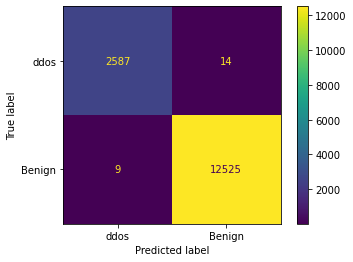

In [47]:
print(clf.score(test2, test_lbl2))
plot_confusion_matrix(clf, test2, test_lbl2, labels=['ddos', 'Benign']);

## AdaBoost
First, we train a decision tree using AdaBoost in combination with Random Grid Search. Afterwards, the same is trained again with a Random Forest Tree. 

In [29]:
param_distributions = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"]
             }

DTC = tree.DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator = DTC)

# run random grid search
grid_search_ABC = RandomizedSearchCV(ABC, param_distributions=param_distributions, n_iter=4)
grid_search_ABC.fit(train, train_lbl)
pd.DataFrame.from_dict(grid_search_ABC.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__splitter,param_base_estimator__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.407470,0.187034,0.049999,0.006356,best,gini,"{'base_estimator__splitter': 'best', 'base_est...",0.997275,0.996696,0.996283,0.997192,0.996944,0.996878,0.000360,4
1,0.351398,0.069019,0.046999,0.003163,random,gini,"{'base_estimator__splitter': 'random', 'base_e...",0.997357,0.997770,0.996201,0.996944,0.997687,0.997192,0.000575,2
2,2.320411,0.140436,0.043197,0.001601,best,entropy,"{'base_estimator__splitter': 'best', 'base_est...",0.997027,0.997687,0.996531,0.996861,0.996696,0.996961,0.000399,3
3,0.273199,0.014986,0.050798,0.006338,random,entropy,"{'base_estimator__splitter': 'random', 'base_e...",0.997770,0.997440,0.997357,0.997770,0.997605,0.997588,0.000168,1


In [38]:
param_distributions = {
    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__bootstrap" :   [True, False],
    "base_estimator__n_estimators": list(np.linspace(10, 300, 20).astype(int))     
}

RFC = RandomForestClassifier()
ABC = AdaBoostClassifier(base_estimator = RFC)

# run random grid search
grid_search_ABC = RandomizedSearchCV(ABC, param_distributions=param_distributions, n_iter=10, verbose = 10)
grid_search_ABC.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223
[CV 1/5; 1/10] END base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223;, score=0.999 total time= 1.1min
[CV 2/5; 1/10] START base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223
[CV 2/5; 1/10] END base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223;, score=0.998 total time= 1.1min
[CV 3/5; 1/10] START base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223
[CV 3/5; 1/10] END base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223;, score=0.999 total time= 1.0min
[CV 4/5; 1/10] START base_estimator__bootstrap=False, base_estimator__criterion=gini, base_estimator__n_estimators=223
[CV 4/5; 1/10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__n_estimators,param_base_estimator__criterion,param_base_estimator__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,64.517217,1.407572,0.352599,0.005816,223,gini,False,"{'base_estimator__n_estimators': 223, 'base_es...",0.998679,0.998282,0.998811,0.999009,0.998414,0.998639,0.000263,4
1,20.326039,2.862984,0.189791,0.005454,101,gini,True,"{'base_estimator__n_estimators': 101, 'base_es...",0.998612,0.998084,0.998612,0.998877,0.998612,0.998560,0.000259,6
2,45.211827,1.443525,0.340586,0.019519,223,entropy,True,"{'base_estimator__n_estimators': 223, 'base_es...",0.998679,0.998018,0.998546,0.998943,0.998480,0.998533,0.000302,8
3,23.841168,0.415413,0.225619,0.005690,132,gini,True,"{'base_estimator__n_estimators': 132, 'base_es...",0.998480,0.998018,0.998546,0.998811,0.998150,0.998401,0.000285,10
4,3.125014,0.081747,0.050988,0.003037,10,gini,False,"{'base_estimator__n_estimators': 10, 'base_est...",0.998414,0.997754,0.998612,0.999009,0.998480,0.998454,0.000406,9
5,13.204135,0.599072,0.142995,0.008502,71,gini,True,"{'base_estimator__n_estimators': 71, 'base_est...",0.998612,0.998150,0.998546,0.998877,0.998546,0.998546,0.000233,7
6,60.208435,5.768668,0.281010,0.027953,177,entropy,False,"{'base_estimator__n_estimators': 177, 'base_es...",0.998679,0.998282,0.998877,0.999273,0.998546,0.998731,0.000333,2
7,98.598755,12.363553,1.130360,0.252209,10,gini,True,"{'base_estimator__n_estimators': 10, 'base_est...",0.998811,0.998282,0.998811,0.999141,0.998678,0.998745,0.000277,1
8,60.414626,2.912780,0.342623,0.035210,208,gini,False,"{'base_estimator__n_estimators': 208, 'base_es...",0.998612,0.998150,0.998877,0.999009,0.998612,0.998652,0.000294,3
9,39.203317,2.315568,0.214689,0.017876,132,gini,False,"{'base_estimator__n_estimators': 132, 'base_es...",0.998612,0.998084,0.998811,0.999141,0.998480,0.998626,0.000351,5


In [39]:
pd.DataFrame.from_dict(grid_search_ABC.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__n_estimators,param_base_estimator__criterion,param_base_estimator__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,64.517217,1.407572,0.352599,0.005816,223,gini,False,"{'base_estimator__n_estimators': 223, 'base_es...",0.998679,0.998282,0.998811,0.999009,0.998414,0.998639,0.000263,4
1,20.326039,2.862984,0.189791,0.005454,101,gini,True,"{'base_estimator__n_estimators': 101, 'base_es...",0.998612,0.998084,0.998612,0.998877,0.998612,0.998560,0.000259,6
2,45.211827,1.443525,0.340586,0.019519,223,entropy,True,"{'base_estimator__n_estimators': 223, 'base_es...",0.998679,0.998018,0.998546,0.998943,0.998480,0.998533,0.000302,8
3,23.841168,0.415413,0.225619,0.005690,132,gini,True,"{'base_estimator__n_estimators': 132, 'base_es...",0.998480,0.998018,0.998546,0.998811,0.998150,0.998401,0.000285,10
4,3.125014,0.081747,0.050988,0.003037,10,gini,False,"{'base_estimator__n_estimators': 10, 'base_est...",0.998414,0.997754,0.998612,0.999009,0.998480,0.998454,0.000406,9
5,13.204135,0.599072,0.142995,0.008502,71,gini,True,"{'base_estimator__n_estimators': 71, 'base_est...",0.998612,0.998150,0.998546,0.998877,0.998546,0.998546,0.000233,7
6,60.208435,5.768668,0.281010,0.027953,177,entropy,False,"{'base_estimator__n_estimators': 177, 'base_es...",0.998679,0.998282,0.998877,0.999273,0.998546,0.998731,0.000333,2
7,98.598755,12.363553,1.130360,0.252209,10,gini,True,"{'base_estimator__n_estimators': 10, 'base_est...",0.998811,0.998282,0.998811,0.999141,0.998678,0.998745,0.000277,1
8,60.414626,2.912780,0.342623,0.035210,208,gini,False,"{'base_estimator__n_estimators': 208, 'base_es...",0.998612,0.998150,0.998877,0.999009,0.998612,0.998652,0.000294,3
9,39.203317,2.315568,0.214689,0.017876,132,gini,False,"{'base_estimator__n_estimators': 132, 'base_es...",0.998612,0.998084,0.998811,0.999141,0.998480,0.998626,0.000351,5


In [ ]:
RFC = RandomForestClassifier(n_estimators = 10, criterion = "gini", bootstrap = True)
ABC = AdaBoostClassifier(base_estimator = RFC, n_estimators = 20)

ABC.fit(train, train_lbl)

In [59]:
ABC.score(test, test_lbl)

0.9984803435744962

## Training a Random Forest Classifier on the whole dataset

In [9]:
df = df.compute()

In [10]:
train, test, train_lbl, test_lbl = train_test_split(df.loc[:, ~df.columns.isin(['Unnamed: 0', "Label"])], df["Label"], test_size=0.2, random_state=1)

#### Random Forest Classifier

In [68]:
RFC = RandomForestClassifier(n_estimators = 40, criterion = "entropy", bootstrap = False)
RFC.fit(train, train_lbl)
RFC.score(test, test_lbl)

0.9998540050510288

In [69]:
dump(RFC, f'models/RandomForestClassifier.model') 

['models/RandomForestClassifier.joblib']

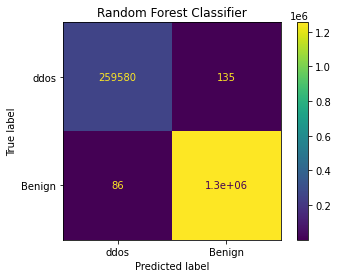

In [26]:
confusion_matrix_RFC = plot_confusion_matrix(RFC, test, test_lbl, labels=['ddos', 'Benign']);
confusion_matrix_RFC.ax_.set_title('Random Forest Classifier')
confusion_matrix_RFC.figure_.savefig('img/confusion_matrix_RFC.png')

#### Random Forest Classifier with AdaBoost

In [64]:
RFC_ABC = RandomForestClassifier(n_estimators = 10, criterion = "gini", bootstrap = True)
ABC_RFC = AdaBoostClassifier(base_estimator = RFC_AB, n_estimators = 20)
ABC_RFC.fit(train, train_lbl)
ABC_RFC.score(test, test_lbl)

0.9998625929892037

In [67]:
dump(ABC_RFC, f'models/RandomForestClassifier_AdaBoost.model')

['models/RandomForestClassifier_AdaBoost.joblib']

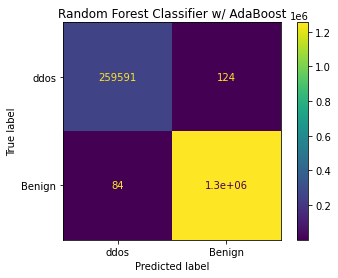

In [29]:
confusion_matrix_ABC_RFC = plot_confusion_matrix(ABC_RFC, test, test_lbl, labels=['ddos', 'Benign']);
confusion_matrix_ABC_RFC.ax_.set_title('Random Forest Classifier w/ AdaBoost')
confusion_matrix_ABC_RFC.figure_.savefig('img/confusion_matrix_ABC_RFC.png')

#### Decision Tree Classifier with AdaBoost

In [70]:
DTC = tree.DecisionTreeClassifier(criterion = "entropy", splitter = "random")
ABC_DTC = AdaBoostClassifier(base_estimator = DTC)
ABC_DTC.fit(train, train_lbl)
ABC_DTC.score(test, test_lbl)

0.9998454171128541

In [71]:
dump(ABC_DTC, f'models/DecisionTreeClassifier_AdaBoost.model')

['models/DecisionTreeClassifier_AdaBoost.joblib']

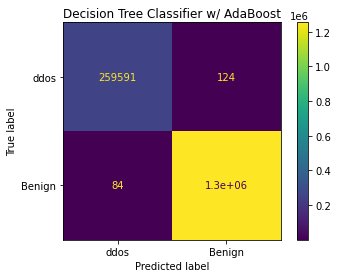

In [31]:
confusion_matrix_ABC_DTC = plot_confusion_matrix(ABC_RFC, test, test_lbl, labels=['ddos', 'Benign']);
confusion_matrix_ABC_DTC.ax_.set_title('Decision Tree Classifier w/ AdaBoost')
confusion_matrix_ABC_DTC.figure_.savefig('img/confusion_matrix_ABC_DTC.png')